In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
# import torchvision.transforms.v2 as transforms

# from torchvision.models.video import s3d, S3D_Weights

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import metrics

# custom libraries
from utils import *
from celebdf2 import *
from main import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the random seed for reproducibility
seed = 50  # You can choose any integer for your seed value
# Set the seed for PyTorch (CPU and CUDA)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setup
# Set the seed for Python's random module
random.seed(seed)
# Set the seed for NumPy
np.random.seed(seed)

In [ ]:
# issues:
# Resolved 1. model is not training
# Resolved 2. when batch size more than 1 need to constict the number of frames
# Resolved 3. crop a small amount then resize
# 4. train using adversial data like black box attacks (random noise)
# Resolved 5. use interval for frames after clipping
# Resolved 6. add logging & save model
# Resolved 7. not whole dataset is used currently only testing samples
# Resolved 8. save logged results in pth file
# Resolved 9. test adamw
# Resolved 10. print running loss & acc since using less epochs
# - save batch results as 2d array
# - save batch results into model file
# 11. train rgb model - Nic
# 12. train optical flow model - Nic
# 13. ensemble learning - Alex
# Resolved 14. plot results - Nic
# Resolved 15. confusion matrix - Nic
# 16. test on sadtalker
# 17. write descriptions for notebook
# 18. updated full ed post

# optical flow
# Resolved 1. resize to 256,256
# Resolved 2. limit frames to 10s
# Resolved 3. sample using interval 15 frames per 1s = 150 frames

## Milestone 3
* Colab / report in colab
* Video

## Milestone 4
* Individual report

In [6]:
# # Load the S3D model with pre-trained weights
# model = s3d(weights=S3D_Weights.DEFAULT)
# model.eval()

S3D(
  (features): Sequential(
    (0): TemporalSeparableConv(
      (0): Conv3dNormActivation(
        (0): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
        (1): BatchNorm3d(64, eps=0.001, momentum=0.001, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Conv3dNormActivation(
        (0): Conv3d(64, 64, kernel_size=(7, 1, 1), stride=(2, 1, 1), padding=(3, 0, 0), bias=False)
        (1): BatchNorm3d(64, eps=0.001, momentum=0.001, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (2): Conv3dNormActivation(
      (0): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=0.001, momentum=0.001, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): TemporalSeparableConv(
      (0): Conv3d

### Grid search sample size

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data"
batch_size = 3 
epochs = 1
train_s3d(dataset_path,batch_size,device,epochs) # 5GB

Input Shape: torch.Size([3, 3, 150, 256, 256])
label Shape: torch.Size([3])
Epoch 1/1
138/138 - Time Taken: 472.832745552063 - train_loss: 0.8223 - train_accuracy: 54.1063% - val_loss: 0.6396 - val_accuracy: 69.2308%


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data"
batch_size = 3
epochs = 1
train_s3d(dataset_path,batch_size,device,epochs) # 4GB

Input Shape: torch.Size([3, 3, 100, 256, 256])
label Shape: torch.Size([3])
Epoch 1/1
138/138 - Time Taken: 334.89113879203796 - train_loss: 0.7019 - train_accuracy: 63.5266% - val_loss: 0.6262 - val_accuracy: 66.3462%


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data"
batch_size = 3
epochs = 1
train_s3d(dataset_path,batch_size,device,epochs) # 3GB

Input Shape: torch.Size([3, 3, 60, 256, 256])
label Shape: torch.Size([3])
Epoch 1/1
138/138 - Time Taken: 244.2112157344818 - train_loss: 0.7697 - train_accuracy: 61.8357% - val_loss: 0.8672 - val_accuracy: 62.5000%


## Final Parameters

### SGD with momentum

In [2]:
# unfreeze + sgd + scaled + full dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data"
batch_size = 5
epochs = 1
train_log, val_log = train_s3d(dataset_path,batch_size,device,epochs) # 7.5GB lr=1e-3

Training size: 6011
Validation size: 518
Input Shape: torch.Size([5, 3, 150, 256, 256])
label Shape: torch.Size([5])
Epoch 1/1
300/1203 - Time Taken: 21.03 - train_loss: 0.7897 - train_accuracy: 69.0667%
600/1203 - Time Taken: 21.17 - train_loss: 0.8013 - train_accuracy: 70.1667%
900/1203 - Time Taken: 21.54 - train_loss: 0.7815 - train_accuracy: 72.3111%
1200/1203 - Time Taken: 21.70 - train_loss: 0.7839 - train_accuracy: 72.3167%
1203/1203 - Time Taken: 93.78 - train_loss: 0.7840 - train_accuracy: 72.3341% - val_loss: 0.6901 - val_accuracy: 60.0386%


### Adam

### AdamW

In [2]:
# freeze + adamw + scaled + test dataset + bigger weight decay
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data"
batch_size = 2
epochs = 3
train_log, val_log = train_s3d(dataset_path,batch_size,device,epochs) # 7.5GB lr=1e-3

Training size: 6011
Validation size: 518
Input Shape: torch.Size([2, 3, 150, 256, 256])
label Shape: torch.Size([2])
Epoch 1/3
200/3006 - Time Taken: 7.89 - train_loss: 0.3211 - train_accuracy: 82.5000%
400/3006 - Time Taken: 7.83 - train_loss: 0.2627 - train_accuracy: 84.8750%
600/3006 - Time Taken: 12.95 - train_loss: 0.2338 - train_accuracy: 85.7500%
800/3006 - Time Taken: 6.77 - train_loss: 0.2105 - train_accuracy: 87.0000%
1000/3006 - Time Taken: 6.68 - train_loss: 0.2112 - train_accuracy: 87.0000%
1200/3006 - Time Taken: 6.67 - train_loss: 0.1972 - train_accuracy: 87.5833%
1400/3006 - Time Taken: 6.64 - train_loss: 0.1935 - train_accuracy: 87.5714%
1600/3006 - Time Taken: 6.66 - train_loss: 0.1893 - train_accuracy: 87.4688%
1800/3006 - Time Taken: 6.64 - train_loss: 0.1907 - train_accuracy: 87.6111%
2000/3006 - Time Taken: 6.63 - train_loss: 0.1906 - train_accuracy: 87.8250%
2200/3006 - Time Taken: 6.62 - train_loss: 0.1854 - train_accuracy: 88.0000%
2400/3006 - Time Taken: 6.64 

In [2]:
# freeze + adamw + scaled + full dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data"
batch_size = 2
epochs = 1
train_log, val_log = train_s3d(dataset_path,batch_size,device,epochs) # 7.5GB lr=1e-3

Training size: 6011
Validation size: 518
Input Shape: torch.Size([2, 3, 150, 256, 256])
label Shape: torch.Size([2])
Epoch 1/1
200/3006 - Time Taken: 5.70 - train_loss: 0.6746 - train_accuracy: 76.5000%
3006/3006 - Time Taken: 13.47 - train_loss: 0.0449 - train_accuracy: 76.5000% - val_loss: 0.6520 - val_accuracy: 65.6371%


In [2]:
# unfreeze + adamw + scaled + full dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data"
batch_size = 2
epochs = 1
train_log, val_log = train_s3d(dataset_path,batch_size,device,epochs) # 7.5GB lr=1e-3

Training size: 6011
Validation size: 518
Input Shape: torch.Size([2, 3, 150, 256, 256])
label Shape: torch.Size([2])
Epoch 1/1
200/3006 - Time Taken: 8.43 - train_loss: 0.6555 - train_accuracy: 83.7500%
3006/3006 - Time Taken: 16.28 - train_loss: 0.0436 - train_accuracy: 83.7500% - val_loss: 2469.2770 - val_accuracy: 34.3629%


In [2]:
# unfreeze + adamw + scaled + full dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data"
batch_size = 2
epochs = 4
train_log, val_log = train_s3d(dataset_path,batch_size,device,epochs) # 7.5GB lr=1e-3

Training size: 6011
Validation size: 518
Input Shape: torch.Size([2, 3, 150, 256, 256])
label Shape: torch.Size([2])
Epoch 1/4
300/3006 - Time Taken: 12.25 - train_loss: 0.5318 - train_accuracy: 85.8333%
600/3006 - Time Taken: 11.56 - train_loss: 0.5150 - train_accuracy: 86.6667%
900/3006 - Time Taken: 10.06 - train_loss: 0.5260 - train_accuracy: 85.1111%
1200/3006 - Time Taken: 9.98 - train_loss: 0.5245 - train_accuracy: 85.9583%
1500/3006 - Time Taken: 9.97 - train_loss: 0.5172 - train_accuracy: 86.6000%
1800/3006 - Time Taken: 9.97 - train_loss: 0.5205 - train_accuracy: 86.8056%
2100/3006 - Time Taken: 10.03 - train_loss: 0.5229 - train_accuracy: 86.8571%
2400/3006 - Time Taken: 9.98 - train_loss: 0.5311 - train_accuracy: 86.7292%
2700/3006 - Time Taken: 10.04 - train_loss: 0.5329 - train_accuracy: 86.5000%
3000/3006 - Time Taken: 9.96 - train_loss: 0.5336 - train_accuracy: 86.5667%
3006/3006 - Time Taken: 111.12 - train_loss: 0.5331 - train_accuracy: 86.5912% - val_loss: nan - val_

In [2]:
# unfreeze + adamw + scaled + full dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data"
batch_size = 2
epochs = 15
train_log, val_log = train_s3d(dataset_path,batch_size,device,epochs) # 7.5GB lr=1e-3

Training size: 466
Validation size: 52
Input Shape: torch.Size([2, 3, 150, 256, 256])
label Shape: torch.Size([2])
Epoch 1/15
233/233 - Time Taken: 10.99 - train_loss: 0.7589 - train_accuracy: 56.0086% - val_loss: nan - val_accuracy: 65.3846%
Epoch 2/15


KeyboardInterrupt: 

### Load model

In [16]:
# path = "s3d_rgb_last_full.pth"
path = "s3d_rgb_last_full_v2.pth"
# replace final layer with new one with appropriate num of classes
# model = s3d(weights=S3D_Weights.DEFAULT)
# model.classifier[1] = nn.Conv3d(1024, 2, kernel_size=1, stride=1)

# # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

checkpoint = torch.load(path, weights_only=False) #, weights_only=True
print(checkpoint.keys())
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_log = checkpoint['train']
val_log = checkpoint['val']
train_run = np.array(checkpoint['train_run'])
val_cm = checkpoint['confusion_matrix']

print(train_log)
print(val_log)
print(train_run.shape)
# print(train_run[0])
# print(train_run[1])

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'train', 'val', 'train_run', 'confusion_matrix'])
[(0.5331238817181302, 0.8659124937614374), (0.5099004924530318, 0.880219597404758), (0.5070253086120822, 0.8810514057561137), (0.5066004553097173, 0.8815504907669273)]
[(nan, 0.6563706563706564), (nan, 0.3996138996138996), (0.6606967906561109, 0.6563706563706564), (1.2406186437284659, 0.6563706563706564)]
(4, 10, 2)


### Plot Training Results

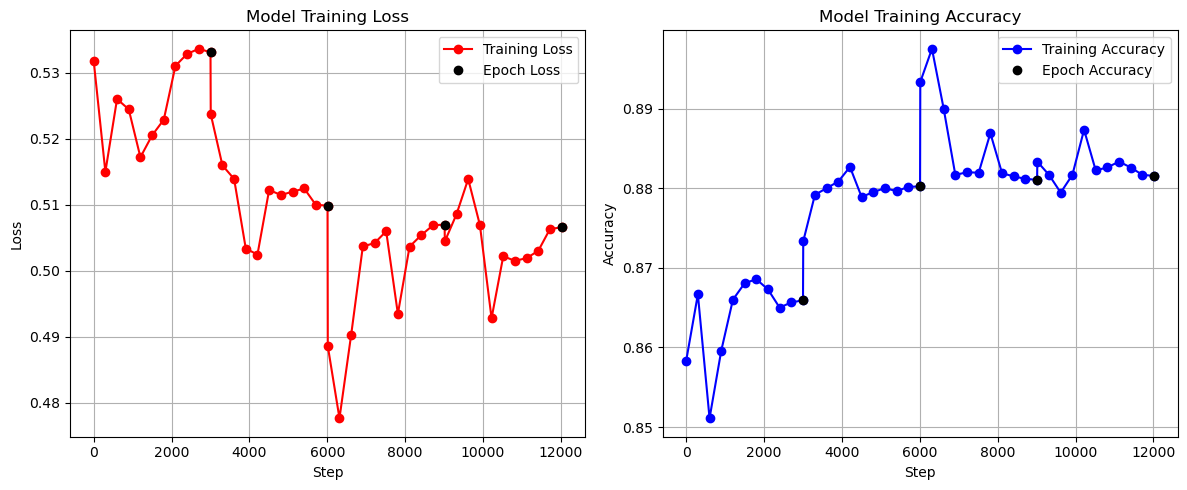

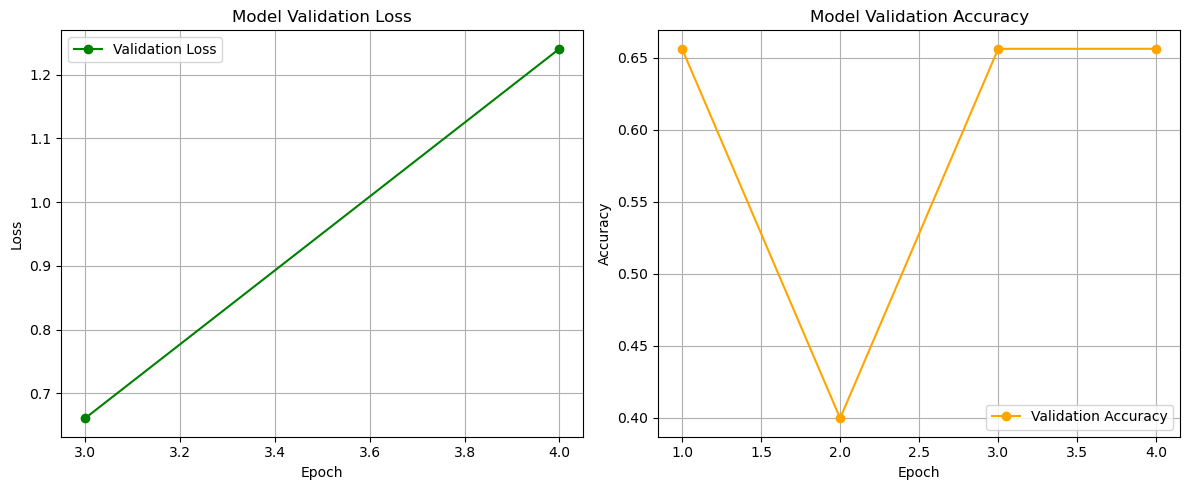

In [19]:
# Separate the losses and accuracies for both training and validation
train_losses = [x[0] for x in train_log]
train_accuracies = [x[1] for x in train_log]

val_losses = [x[0] for x in val_log]
val_accuracies = [x[1] for x in val_log]

# Generate the x-axis values (assuming each data point is an epoch)
epochs = np.arange(1, len(train_log) + 1)

# Separate the step losses and accuracies for both training and validation
train_step_loss = []
train_step_acc = []

for i, epoch in enumerate(train_run):
    for point in epoch:
        train_step_loss.append(point[0])
        train_step_acc.append(point[1])

    train_step_loss.append(train_losses[i])
    train_step_acc.append(train_accuracies[i])

# print(len(train_step_loss))
# print(train_step_loss[0:17])
# print(len(train_step_acc))
# print(train_step_acc[0:17])

# x-axis for training plot
step_range = np.array([])
# print(epochs)

for i in epochs:
    range = np.arange(start=((i-1)*3006), stop=i*3006, step=300)
    step_range = np.append(step_range,range).astype(int)

# print(step_range)

# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(step_range, train_step_loss, label='Training Loss', marker='o', color='r')
plt.plot(epochs*3006, train_losses, marker='o', color='k',linestyle='',label='Epoch Loss')
plt.title('Model Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(step_range, train_step_acc, label='Training Accuracy', marker='o', color='b')
plt.plot(epochs*3006, train_accuracies, marker='o', color='k',linestyle='',label='Epoch Accuracy')
plt.title('Model Training Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, label='Validation Loss', marker='o', color='g')
plt.title('Model Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='orange')
plt.title('Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### Confusion Matrix

Training size: 6011
Validation size: 518
Input Shape: torch.Size([5, 3, 150, 256, 256])
label Shape: torch.Size([5])
Train_loader


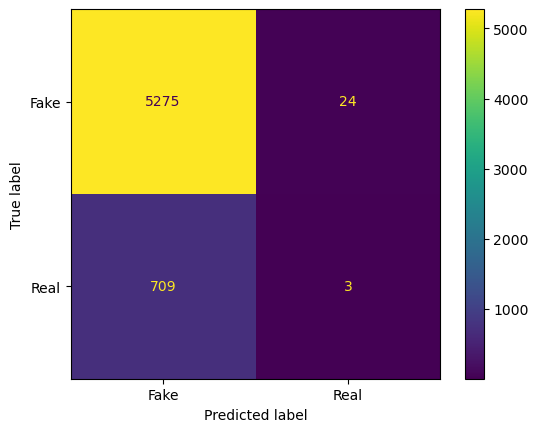

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "data"
model_path = "s3d_rgb_last_full_v2.pth"
batch_size = 5
train_loss, train_accuracy, train_cm = eval_s3d(dataset_path,batch_size,device,model_path)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = train_cm, display_labels = ['Fake', 'Real'])

cm_display.plot()
plt.show()

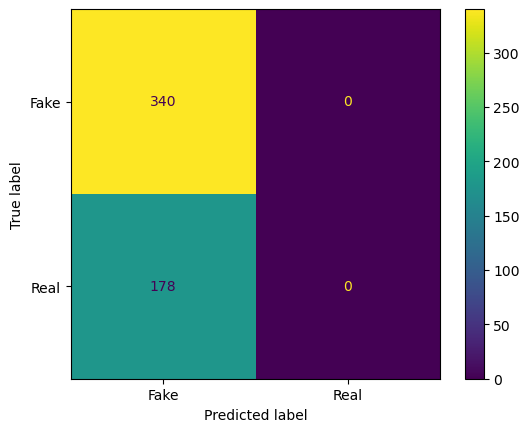

In [17]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = val_cm, display_labels = ['Fake', 'Real'])

cm_display.plot()
plt.show()